#  Dynamic systems with limited memory

In this short post we pick up on our previous conversation on [one dimensional convolutions](https://blog.dgsix.com/posts/one_dimensional_convolutions/One_dimensional_convolutions.html), discussing their generalization called *dynamic systems with limited memory*.

You can skip around this document to particular subsections via the hyperlinks below.

-  [Dynamic systems with limited memory](#dynamic-systems-intro)
-  [A range of examples](#examples)

In [ ]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library for animations
import sys
sys.path.append('../../')
from demo_libraries import dyamic_systems_limited_memory_library as dynalib

# import standard libs
import numpy as np
import pandas as pd
from IPython.display import clear_output

# path to data
datapath = '../../datasets/plain_timeseries/'

# This is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

<a id='dynamic-systems-intro'></a>
## Dynamic systems with limited memory

A one dimensional convolution consists of a simple linear combination of $D$ consecutive elements of an ordered sequence

\begin{equation}
h_{p} = w_1x_{p-1} + w_2x_{p-2} + \cdots + w_{D}x_{p-D}.
\end{equation}

More generally, instead of a linear combination we can use any general function $f\left(\cdot\right)$ one desires asas 

\begin{equation}
h_{p} = f\left(x_{p-1},x_{p-2},\cdots,x_{p-D}\right).
\end{equation}

Such a functional relationship is generally referred to as a *dynamic system with limited memory*.  Breaking this jargon-phrase apart, the "dynamic system" part simply refers to the fact that the function $f\left(\cdot\right)$ takes in elements of a naturally ordered sequence (like a time series).  The "limited memory" part simply refers to the fact that each output $h_p$ is *only* dependent on the previous $D$ elements of an input sequence $(x_{p-1},x_{p-2},\cdots,x_{p-D}$ (that is, it only has "memory" of these inputs).

<a id='examples'></a>
## A range of examples

Dynamic systems with limited memory - where $f$ is chosen based on particular specifications - are used throughout the sciences, economics, and engineering.  Indeed we have already seen several specific examples in the form of the [moving average](https://blog.dgsix.com/posts/one_dimensional_convolutions/One_dimensional_convolutions.html) and various [convolutions](https://blog.dgsix.com/posts/one_dimensional_convolutions/One_dimensional_convolutions.html#generalizing-moving-average).  Below we briefly illustrate a few additional examples, including those that output is *vector-valued*, that is systems that take the form

\begin{equation}
\mathbf{h}_{p} = f\left(x_{p-1},x_{p-2},\cdots,x_{p-D}\right)
\end{equation}

where $\mathbf{h}$ is some $M$ length vector.  These often arise as some kind of *histogram* that summarizes the input values $x_{p-1},x_{p-2},\cdots,x_{p-D}$ somehow, when using classical signal processing tools like the Discrete Cosine Transform, and when using a multi-layer perceptron.

#### <span style="color:#a50e3e;">Example 1: </span>  A maximum intake

A simple example (which we have not seen previously) is the *maximum* system defined as 

\begin{equation}
h_{p} = \text{maximum}\left(x_{p-1},x_{p-2},\cdots,x_{p-D}\right)
\end{equation}

which simply outputs the maximum value in a $D$ length window of the input.  This simple system can be implemented in `Python` as shown below.  This `model` function takes in the input sequence `x` and a window-length $D$ and returns the desired transformation $h$.

In [9]:
# a simple implementation of the maximum system
def model(x,D):
    # set initial condition
    h = [v for v in x[:D]]
    
    # loop over remainder of sequence and take maximum of each D length window
    for p in range(len(x) - D):
        # compute maximum of current window and store
        h_p = np.max(x[p:p+D])
        h.append(h_p)
    return np.array(h)

Below we show an animation of the maximum system computed over an input sequence shown in black.  The window (whose size here is $D = 5$) is shown moving from left to right, strattled on both sides by vertical blue guide-lines.  The resulting maximum computation is then shown sequentially in orange.

In [24]:
## This code cell will not be shown in the HTML version of this notebook
# generate test series
x = []
for t in range(50):
    x_t = 0.1*t*np.sin(0.5*t)
    x.append(x_t)    
x = np.array(x)

# produce moving average time series
D = 5
y = model(x,D)

# run animator
demo = dynalib.dynamic_systems_animators.Visualizer()
demo.animate_system(x,y,D,savepath='videos/animation_1.mp4',fps=5)
clear_output()

# import video into notebook
from IPython.display import HTML
HTML("""
<video width="1000" height="400" controls loop>
  <source src="videos/animation_1.mp4" type="video/mp4">
  </video>
""")

Below we show the result of applying the maximum system to this same input series, adjusting the window size $D$ from $D=1$ to $D=19$.  As the value of $D$ increases the corresponding maximum sequence starts to look more and more like a bounding [envelope](https://en.wikipedia.org/wiki/Envelope_(waves)).

In [22]:
## This code cell will not be shown in the HTML version of this notebook
# run animator    
demo = dynalib.dynamic_systems_animators.Visualizer()
params = np.arange(1,20)
func = lambda x,D,f=maximum: model(x,D,f)
demo.animate_system_range(x,func,params,savepath='videos/animation_2.mp4',fps=4)
clear_output()


from IPython.display import HTML
HTML("""
<video width="1000" height="400" controls loop>
  <source src="videos/animation_2.mp4" type="video/mp4">
  </video>
""")

#### <span style="color:#a50e3e;">Example 2: </span>  Limited memory normalized histogram

Perhaps the simplest example of a vector-valued dynamic system is a running *histogram*.  That is, a function that takes in $D$ sequential elements of an ordered input sequence and outputs a histogram summarizing the content of this window of values.  A range basic choices need be made when defining a histogram - including the number of bins to use, the value of these bins, lower and upper bounds for the histogram, etc.,  Below we define a simple `histogram_function` in `Python` that takes in the snippet of input values $x_{p-1},x_{p-2},\cdots,x_{p-D}$ and provides a few optional input arguments for controlling these basic histogram parameters.  This histogram is normalized near the end so that it can be treated like a [discrete probability distribution](https://jermwatt.github.io/machine_learning_refined/notes/7_Linear_multiclass_classification/7_5_Categorical.html), and returned along with the bins used.  This is an example of a function $f\left(\cdot\right)$ in the general dynamic system shown in Equation (4).

In [10]:
## This code cell will not be shown in the HTML version of this notebook
def histogram_function(x,**kwargs):
    # define range of histogram and resolution
    lower_bound = -1
    upper_bound = 1
    resolution = 20
    if 'lower_bound' in kwargs:
        lower_bound = kwargs['lower_bound']
    if 'upper_bound' in kwargs:
        upper_bound = kwargs['upper_bound']
    if 'resolution' in kwargs:
        resolution = kwargs['resolution']
        
    # clip input series based on lower bound / upper bound
    x = np.array(x)
    ind = np.argwhere(x < lower_bound)
    if len(ind) > 0:
        x[ind] = lower_bound
    ind = np.argwhere(x > upper_bound)
    if len(ind) > 0:
        x[ind] = upper_bound
    
    # make base histogram
    h,bins = np.histogram(x, bins=np.linspace(lower_bound,upper_bound,resolution+1), density=False)
    h = np.array([v/len(x) for v in h])
    return h,bins

Below we animate the result of applying this dynamic system on a toy input sequence, shown in black in the top panel of the figure. In each frame of the animation the current window (here $D = 10$) is once again illustrated by two vertical blue guide-lines, and here the points inside each window are highlighted orange.  In the middle panel of the Figure we show the normalized histogram of values in each window in magenta, and in the bottom we illustrate all of the histograms generated up to the current frame via a *heatmap*.  Here each histogram is rotated $90$ degrees, and we view them from above.  The darker orange colors correspond to higher values in each histogram.

In [ ]:
## This code cell will not be shown in the HTML version of this notebook
# generate test series
x = []
for t in range(50):
    x_t = np.sin(t) + t*0.2
    x.append(x_t)  
    
# produce moving average time series
D = 10
func = lambda x: histogram_function(x,lower_bound=0,upper_bound=10,resolution=100)

# general linear filter function - which takes in dynamic systems function f
# for the sake of generality in the animation process
def vector_model(x,D,f):
    # initialize
    h = []
    
    # loop over and create histograms
    for p in range(len(x) - D + 2):
        # make next element
        x_p = x[p:p+D]
        h_p,bins = f(x_p)
        y.append(h_p)
    return y

# run animator
demo = dynalib.dynamic_systems_animators.Visualizer()
demo.animate_vector_histogram(x,D,vector_model,func,savepath='videos/animation_4.mp4',fps=5)
clear_output()

In [15]:
## This code cell will not be shown in the HTML version of this notebook
from IPython.display import HTML
HTML("""
<video width="1000" height="1000" controls loop>
  <source src="videos/animation_4.mp4" type="video/mp4">
  </video>
""")

#### <span style="color:#a50e3e;">Example 3: </span>  The Discrete Cosine Transform and spectrograms

The *Discrete Cosine Transform* (or DCT for short) is a common dynamic system employed with audio and more generally electrical signals for compression and other various processing tasks.  The gist of a DCT is illustrated in the image below (taken with permission [from this website](https://jermwatt.github.io/machine_learning_refined/notes/9_Feature_engineer_select/9_2_Histogram.html)) for a snippet of signal below.  Here the signal (left panel) is approximated by a weighted sum of cosine waves of increasing frequency (middle panel), with the resulting transformation, also called the signals *frequency* or *spectrum*, consisting of the magnitude of the coefficients of this transformation.

<figure>
<img src="images/Figure_9_10.png" width="80%" height="auto"/>
<figcaption> <strong></em> 
</figcaption>
</figure>

A formulae for this DCT transformation can be found e.g., on [wikipedia](https://en.wikipedia.org/wiki/Discrete_cosine_transform), and can be used as the function $f\left(\cdot\right)$ in Equation (4).  The DCT of a snippet can be computed in `Python` using [`scipy`](https://www.scipy.org/), and imported via the statement below

```
from scipy.fftpack import dct
```

Below we animate the process of generating DCT transformations for a moving window over an input signal.  At each frame the windowed signal (here $D = 128$) is highlighted in magenta.  As with the histogram example given above, here we illustrate each DCT contiguously in the bottom panel as a *heatmap* - viewing the histogram from above vertically.  Here blue denotes small values and red large ones. 

 This view of the running DCT transformations is very similar to the concept of a [spectrogram](https://en.wikipedia.org/wiki/Spectrogram).  Also note that in machine learning such a dynamic system is often referred to as a [histogram-based feature transformation](https://jermwatt.github.io/machine_learning_refined/notes/9_Feature_engineer_select/9_2_Histogram.html).  

In [36]:
## This code cell will not be shown in the HTML version of this notebook
# general linear filter function
def vector_model(x,D,f):
    # filter input signal
    y = []
    for p in range(len(x) - D + 1):
        # make next element
        x_p = x[p:p+D]
        h = np.abs(f(x_p))
        y.append(h)
    return np.array(y).T

In [ ]:
## This code cell will not be shown in the HTML version of this notebook
# load in data
csvname =  'data/dog_audio.csv'
data = pd.read_csv(csvname)
x = np.array(data).flatten()

# subsample data
x = x[::40]
x = x[100:]

# normalize
x_mean = np.mean(x)
x_std = np.std(x)
x = (x - x_mean)/x_std

# produce moving average time series
from scipy.fftpack import dct
D = 80
func = dct

# run animator
demo = dynalib.dynamic_systems_animators.Visualizer()
demo.animate_dct_spectrogram(x,D,vector_model,func,savepath='videos/animation_5.mp4',fps=80)
clear_output()

In [105]:
## This code cell will not be shown in the HTML version of this notebook
# load animation into notebook
from IPython.display import HTML
HTML("""
<video width="1000" height="1000" controls loop>
  <source src="videos/animation_5.mp4" type="video/mp4">
  </video>
""")

#### <span style="color:#a50e3e;">Example 4: </span>  A multi-layer perceptron

A [multi-layer perceptron](https://jermwatt.github.io/machine_learning_refined/notes/13_Multilayer_perceptrons/13_2_Multi_layer_perceptrons.html) can also be used as a function $f\left(\cdot\right)$ in Equation (4).  In the top panel of the image below we show the same input signal used in the previous Example.  In the three panels below it we show the output of a random unit from the first, second, and third hidden layer of a three layer network with ReLU activations, respectively.  This network takes in precisely the windows (of size $D = 128$) of the signal shown in the previous DCT animation.

In [2]:
## This code cell will not be shown in the HTML version of this notebook
# create initial weights for arbitrary feedforward network
def initialize_network_weights(layer_sizes, scale):
    # container for entire weight tensor
    weights = []
    
    # loop over desired layer sizes and create appropriately sized initial 
    # weight matrix for each layer
    for k in range(len(layer_sizes)-1):
        # get layer sizes for current weight matrix
        U_k = layer_sizes[k]
        U_k_plus_1 = layer_sizes[k+1]

        # make weight matrix
        weight = scale*np.random.randn(U_k+1,U_k_plus_1)
        weights.append(weight)

    # re-express weights so that w_init[0] = omega_inner contains all 
    # internal weight matrices, and w_init = w contains weights of 
    # final linear combination in predict function
    w_init = [weights[:-1],weights[-1]]
    
    return w_init

In [3]:
## This code cell will not be shown in the HTML version of this notebook
# a feature_transforms function for computing
# U_L L layer perceptron units efficiently
def activation(s):
    return np.maximum(0,s)
    
def feature_transforms(a, w):    
    # loop through each layer matrix
    hidden_outputs = []
    for W in w:
        # compute inner product with current layer weights
        a = W[0] + np.dot(a.T, W[1:])

        # output of layer activation
        a = activation(a).T
        
        # store hidden outputs
        hidden_outputs.append(a)
    return a,hidden_outputs

# an implementation of our model employing a nonlinear feature transformation
def model(x,w):    
    # feature transformation 
    f,hidden_outputs = feature_transforms(x,w[0])
    
    # compute linear combination and return
    a = w[1][0] + np.dot(f.T,w[1][1:])
    return a.T

# window input series
def window_series(x,D):
    xwins = []
    for d in range(len(x) - D + 1):
        x_p = x[d:d+D]
        xwins.append(x_p)
    xwins = np.array(xwins)
    return xwins.T

In [5]:
## This code cell will not be shown in the HTML version of this notebook
# load in data
csvname =  'data/dog_audio.csv'
data = pd.read_csv(csvname)
x = np.array(data).flatten()

# subsample data
x = x[::40]
x = x[100:]

# normalize
x_mean = np.mean(x)
x_std = np.std(x)
x = (x - x_mean)/x_std

# window series
D = 128
xwins = window_series(x,D)

layer_sizes = [D,10,10,10,1]
w = initialize_network_weights(layer_sizes,scale=0.5)
a,hidden_outputs = feature_transforms(xwins,w[0])

<IPython.core.display.Javascript object>


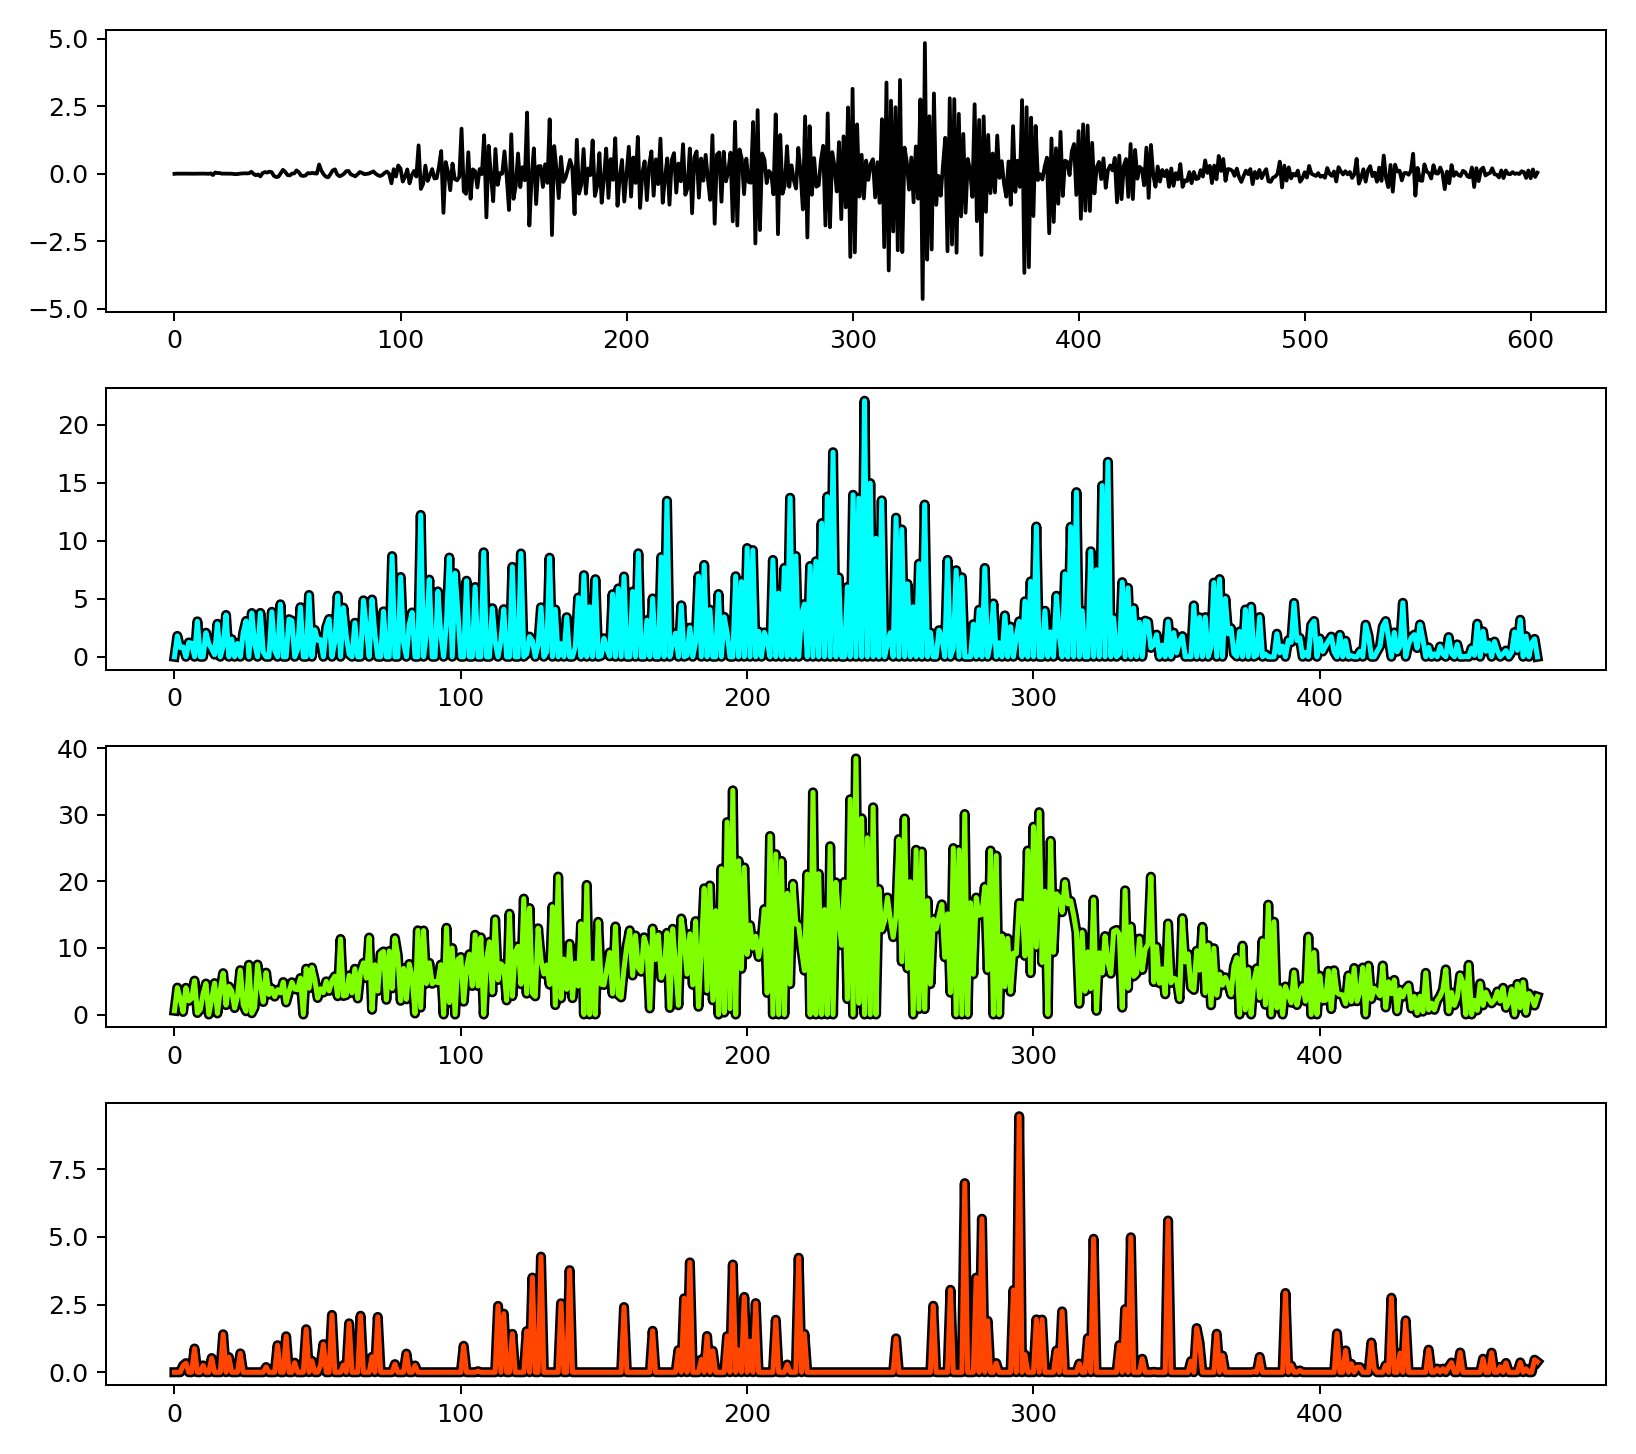

In [10]:
## This code cell will not be shown in the HTML version of this notebook
import matplotlib.pyplot as plt
from matplotlib import gridspec

def plot_it(x,hidden_outputs):
    # produce figure
    fig = plt.figure(figsize = (9,8))
    gs = gridspec.GridSpec(len(hidden_outputs)+1, 1) 
    ax = plt.subplot(gs[0]); 
    layer_colors = ['cyan','chartreuse','orangered']

    # plot 
    ax.plot(x,c='k')
    
    # plot hidden layers
    for layer in range(len(hidden_outputs)):
        ax1 = plt.subplot(gs[layer+1]); 

        h = hidden_outputs[layer]
        c = layer_colors[layer]

        unit = np.random.permutation(h.shape[0])[0]
        u = 'k'
        h_u = h[unit]
        ax1.plot(h_u,color=u,linewidth=4)
        ax1.plot(h_u,color=c,linewidth=2)
    plt.show()
    
plot_it(x,hidden_outputs)